In [1]:
from astropy import units as u
from scepter import tleforger
import numpy as np
import cysgp4
from astropy import time as astrotime
from datetime import datetime
from scepter import scenario
from tqdm.auto import tqdm
from scepter.skynet import pointgen_S_1586_1
from pycraf.geometry import true_angular_distance
from pycraf.antenna import ras_pattern
from pycraf import conversions as cnv

c:\Users\boris.sorokin\AppData\Local\miniforge3\envs\scepter-dev\lib\site-packages\cysgp4\helpers.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [ ]:
tleforger.reset_tle_counter()
belt_names = []
belt_sats = []
altitudes = []
tle_list = []


# ==========================================
# Copy this section to have different belts
# ==========================================
belt_name='System1_Belt_1'
num_sats_per_plane = 40
plane_count = 18
altitude = 1200 * u.km
eccentricity = 0.0
inclination_deg = 87.9 * u.deg
argp_deg = 0.0 * u.deg
RAAN_min = 0 * u.deg
RAAN_max = 180 * u.deg


tle_list_local = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, 
                                            plane_count=plane_count, RAAN_min=RAAN_min, 
                                            RAAN_max=RAAN_max, altitude=altitude, eccentricity=eccentricity, inclination_deg=inclination_deg, 
                                            argp_deg=argp_deg, adjacent_plane_offset=False)

belt_names.append(belt_name)
belt_sats.append(len(tle_list_local))
altitudes.append(altitude)
tle_list.extend(tle_list_local)

# # ==========================================
# # Copy this section to have different belts
# # ==========================================
# belt_name='System2_Belt_1'
# num_sats_per_plane = 40
# plane_count = 36
# altitude = 550 * u.km
# eccentricity = 0.0
# inclination_deg = 45 * u.deg
# argp_deg = 0.0 * u.deg
# RAAN_min = 0 * u.deg
# RAAN_max = 360 * u.deg


# tle_list_local = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, 
#                                             plane_count=plane_count, RAAN_min=RAAN_min, 
#                                             RAAN_max=RAAN_max, altitude=altitude, eccentricity=eccentricity, inclination_deg=inclination_deg, 
#                                             argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_names.append(belt_name)
# belt_sats.append(len(tle_list_local))
# altitudes.append(altitude)
# tle_list.extend(tle_list_local)

# ==========================================
# Wrap in numpy
# ==========================================
belt_sats = np.array(belt_sats)
altitudes = np.array(altitudes, dtype=object)
tle_list = np.array(tle_list, dtype=object)

In [ ]:
latitude = -30.712777 * u.deg
longitude = 21.443611 * u.deg
elevation = 1052.0 * u.m
SKAO=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)

SKAO_ant_diam = 15 * u.m
observer_list=[SKAO]
print(f'RAS station(s) defined as {observer_list}')
observer_list=np.array(observer_list)

RAS station(s) defined as [<PyObserver: 21.4436d, -30.7128d, 1.0520km>]


In [ ]:
#Reshaping the inputs
observers_new=observer_list[np.newaxis, :, np.newaxis]
tles_new=tle_list[np.newaxis, np.newaxis, :]

In [ ]:
_BULK_TIMESTAMPS=10
start_time = astrotime.Time(datetime(2025, 1, 1, 0, 0, 0))
end_time =  astrotime.Time(datetime(2025, 1, 1, 10, 0, 0))
timestep = 10 # steps in seconds
time_batches=scenario.generate_simulation_batches(start_time, end_time, timestep, _BULK_TIMESTAMPS)

n_times = len(time_batches['times'][0])  # total frames per batch
n_batches = len(time_batches['times'])  # total frames per batch
print(f'Simulation will include approximately {n_times} time stamps for each of {n_batches} batches')

Simulation will include approximately 10 time stamps for each of 361 batches


In [ ]:
_STORAGE_FILENAME="simulation_results.h5"
scenario.init_simulation_results(_STORAGE_FILENAME)
FREQUENCY = 10700 * u.MHz
wavelength = FREQUENCY.to(u.m, equivalencies=u.spectral())

In [ ]:
for i in (pbar := tqdm(range(n_batches), desc='Processing time slices:', leave=True)):
    local_times = time_batches['times'][i]
    n_local_times = len(local_times)
    mjds_new=local_times.mjd[:, np.newaxis, np.newaxis]
    # Simualte satellite movement
    pbar.set_description("Processing satellite positions")
    result = cysgp4.propagate_many(mjds_new, 
                                tles_new, 
                                observers_new, 
                                do_eci_pos=False, 
                                do_eci_vel=False, 
                                do_geo=False, 
                                do_topo=True,
                                do_obs_pos=False,
                                do_sat_azel=False,
                                do_sat_rotmat=False,
                                sat_frame='xyz')
    sat_topo=result['topo'] # anges to satellites in local observers' frames
    # sat_topo provides (az,el,dist,dist_rate)

    # Generate sky cell pointings
    tel_az, tel_el, _ = pointgen_S_1586_1(n_local_times)
    sat_position_az = sat_topo[:, 0, :, 0]
    sat_position_el = sat_topo[:, 0, :, 1]

    offset_deg_grx = true_angular_distance(tel_az[:, :, np.newaxis]*u.deg, tel_el[:, :, np.newaxis]*u.deg, 
                                    sat_position_az[:, np.newaxis, :]*u.deg, sat_position_el[:, np.newaxis, :]*u.deg)
    pbar.set_description("Processing power")

    
    Grx    = ras_pattern(offset_deg_grx,    SKAO_ant_diam, wavelength)
    Ptx=np.broadcast_to(1, Grx.shape)*u.W
    Gtx = 0*cnv.dBi
    distances_2RAS = sat_topo[:, 0, :, 2]
    distances_2RAS_full=np.broadcast_to(distances_2RAS[:,np.newaxis,:],Grx.shape) * u.km

    Prx    = cnv.prx_from_ptx(Ptx,    Gtx,    Grx,    distances_2RAS_full,    FREQUENCY)

    mask=(sat_position_el >= 0) 
    mask_full=np.broadcast_to(mask[:,np.newaxis,:],Grx.shape)

    Prx[mask_full]    = np.nan * u.W
    Ptx[mask_full]    = np.nan * u.W

    powerflux_2RAS    = cnv.powerflux_from_ptx(Ptx,    distances_2RAS_full,    Gtx)
    epfd_0_per_source    = (powerflux_2RAS.to(cnv.dB_W_m2)    + Grx).to(u.W/u.m**2)

    epfd_0    = np.nansum(epfd_0_per_source,    axis=(-1))

    times_array = local_times.mjd
    pbar.set_description("Storing results")
    append_axis = 0 if i == 0 else 1

    scenario.store_iter_batch(
        _STORAGE_FILENAME,
        iteration=1,
        times=times_array,
        epfd_0=epfd_0
    )

    if i == n_batches - 1:
        pbar.set_description("Finished")

    
                                                                            

Processing time slices::   0%|          | 0/361 [00:00<?, ?it/s]

In [1]:
from scepter import scenario, visualise
from pycraf import conversions as cnv

_STORAGE_FILENAME="simulation_results.h5"
results = scenario.read_iter_results(_STORAGE_FILENAME, stack=True)
# results = scenario.read_simulation_results(_STORAGE_FILENAME)
print(results.keys())

c:\Users\boris.sorokin\AppData\Local\miniforge3\envs\scepter-dev\lib\site-packages\cysgp4\helpers.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


dict_keys(['Prx', 'Prx_BA', 'epfd_0', 'epfd_0_BA', 'powerflux_2RAS', 'powerflux_2RAS_BA', 'times', 'total_Prx', 'total_Prx_BA'])


In [2]:
epfd_0_recovered=results["epfd_0"]#[0,:,:]
timestep,_ = scenario.analyse_time(results["times"][0,:])
print(f"Detected timestep is {timestep}")
timestep=timestep.value
window_size = int(2000 / timestep)
from scipy.ndimage import uniform_filter1d
epfd_0_recovered_smoothed = uniform_filter1d(epfd_0_recovered, size=window_size) * (epfd_0_recovered.unit)

Detected timestep is 0.9999999997671694 s


In [3]:
epfd_0_recovered_smoothed.to(cnv.dB_W_m2).shape

(10, 181, 2334)

In [74]:
from __future__ import annotations

from typing import Any, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Try to reuse your helper; otherwise fall back to a local one.
try:
    from scepter.visualise import _to_plain_array  # returns (np.ndarray, unit-or-None)
except Exception:
    try:
        from astropy import units as u  # only used in the fallback
    except Exception:
        u = None  # type: ignore

    def _to_plain_array(data: Any) -> Tuple[np.ndarray, Any]:
        """Fallback: convert Quantity→(values, unit) else (array, None)."""
        if hasattr(data, "unit"):
            return np.asarray(data.value), getattr(data, "unit")
        return np.asarray(data), None


def plot_S_1586_1_cdf_ccdf_bounds(
    data: Any,
    *,
    # --- INPUT / PREP ---
    cell_axis: int = -1,               # which axis has the 2334 skycells; others are flattened
    num_points: int = 1000,            # x-grid resolution
    log_mode: bool = True,             # do CDF math in linear if data is dB-like

    # --- PLOT CHOICE ---
    plot_type: str = "ccdf",           # "cdf" or "ccdf"
    label: str = "epfd",               # x-axis label base (unit appended automatically)

    # --- WHAT TO SHOW ---
    show_bounds: bool = True,
    show_total: bool = True,
    show_mean: bool = True,
    show_median: bool = True,
    show_two_percent: bool = True,     # 2% (CCDF) / 98% (CDF)
    show_five_percent: bool = False,   # 5% (CCDF) / 95% (CDF)

    # --- MARKERS & ANNOTATIONS ---
    show_percent_markers_on_curves: bool = True,
    annotate_percent_values: bool = True,
    # per-curve marker toggles
    show_marker_total: bool = True,
    show_marker_mean: bool = True,
    show_marker_median: bool = True,

    # --- PROTECTION CRITERION LINES ---
    prot_value: Any | None = None,          # float/Quantity or sequence thereof
    prot_legend: list[str] | None = None,   # optional legend entries (align with prot_value)
    prot_linestyle: str | list[str] = "-.",
    prot_linewidth: float | list[float] = 1.3,
    prot_color: Any | list[Any] | None = None,

    # --- LIMITS / RENDERING ---
    y_min_percent: float | None = None,     # CCDF lower y-limit override (log scale)
    show: bool = True,

    # --- COMPUTE OVERRIDES (let you compute hidden stuff even if not shown) ---
    compute_bounds: bool | None = None,
    compute_mean: bool | None = None,
    compute_median: bool | None = None,
    compute_total: bool | None = None,
) -> plt.Figure:
    """
    Plot CDF or CCDF from multi-cell simulation data, with optional bounds envelope,
    total/mean/median curves, per-curve percentile markers, and vertical protection
    lines. Works with inputs where **one axis is the 2334 S.1586 skycells** and all
    other axes (time, iterations, etc.) are **flattened** into samples.

    Parameters
    ----------
    data : array-like or astropy.units.Quantity
        Shape (..., 2334, ...) where `cell_axis` indexes the skycells.
        All other axes are flattened into the sample axis per cell. If a Quantity,
        its unit is preserved for the x-axis label and value annotations.
        Examples:
          • (time, cells)               -> cell_axis=1
          • (iter, time, cells)         -> cell_axis=2
          • (cells, time)               -> cell_axis=0

    cell_axis : int
        Axis index of the 2334 skycells. Negative indices are allowed. All other
        axes are flattened into samples per cell.

    num_points : int
        Number of points for the common x-grid used to interpolate all CDFs.

    log_mode : bool
        If True, treat inputs as dB-like: convert to linear for CDF math and
        convert the x-grid back to dB for plotting. If False, work in linear.

    plot_type : {"cdf","ccdf"}
        Selects CDF or CCDF rendering.

    label : str
        Base x-axis label. If input `data` was a Quantity, its unit is appended.

    show_* : bool
        Toggles for envelope (`show_bounds`), total/mean/median curves, and
        2%/5% reference lines. For CDF, 2%/5% map to 98%/95% respectively.

    show_percent_markers_on_curves : bool
        If True, place a marker with value annotation at the selected percent
        (2%/5% for CCDF, 98%/95% for CDF) on the visible curves.

    show_marker_total/mean/median : bool
        Fine-grained control for which visible curves get markers.

    prot_value : float/Quantity or sequence
        Optional vertical line(s) at protection criterion value(s). The x-axis
        is automatically extended to include them.

    prot_legend : list[str] or None
        Legend entries aligned to `prot_value`. Use None to auto-generate.

    y_min_percent : float or None
        For CCDF (log y), you can force a lower y-limit (e.g., 1.0).

    compute_* : bool or None
        Force computation of bounds/mean/median/total irrespective of show flags.
        By default, we compute only what we need to plot.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The Matplotlib figure.

    Notes
    -----
    • Percentile markers appear **only** for enabled percent levels **and** only
      on curves that are actually visible and whose per-curve marker flag is True.
    • The bounds envelope is the min/max across **per-cell CDF curves** evaluated
      on a common x-grid. The total curve pools **all samples across all cells**.
    """
    # ------------------------------ helpers ------------------------------
    def _snap_to_grid(val: float, grid: np.ndarray) -> float:
        idx = np.argmin(np.abs(grid - val))
        return grid[idx]

    def _x_at_cdf_percent(cdf_percent_curve: np.ndarray, target_percent: float, x_grid: np.ndarray) -> float:
        # cdf_percent_curve is 0..100 monotonic; returns x where CDF hits target (snapped)
        x_val = np.interp(target_percent, cdf_percent_curve, x_grid)
        return _snap_to_grid(x_val, x_grid)

    # ----------------------- normalize & flatten -----------------------
    arr, unit = _to_plain_array(data)

    if arr.ndim < 2:
        raise ValueError(f"'data' must have at least 2 dims; got {arr.shape}.")

    # normalize cell_axis
    if cell_axis < 0:
        cell_axis = arr.ndim + cell_axis
    if not (0 <= cell_axis < arr.ndim):
        raise ValueError(f"cell_axis {cell_axis} out of range for shape {arr.shape}.")
    if arr.shape[cell_axis] != 2334:
        raise ValueError(f"Expected axis {cell_axis} to be 2334 skycells; got {arr.shape[cell_axis]}.")

    # move cells to last axis; flatten everything else -> (samples, 2334)
    arr = np.moveaxis(arr, cell_axis, -1)
    C = arr.shape[-1]  # 2334
    samples = arr.reshape(-1, C)

    # convert to linear if requested
    if log_mode:
        samples = np.power(10.0, samples / 10.0)

    # common x-grid in linear
    all_vals = samples[np.isfinite(samples)].ravel()
    if all_vals.size == 0:
        raise ValueError("No finite values found in input.")
    vmin_lin = float(np.min(all_vals))
    vmax_lin = float(np.max(all_vals))
    if vmin_lin == vmax_lin:
        vmax_lin = vmin_lin + 1.0  # avoid degeneracy
    x_grid_lin = np.linspace(vmin_lin, vmax_lin, int(num_points))

    # compute flags
    do_bounds  = show_bounds if compute_bounds  is None else bool(compute_bounds)
    do_mean    = show_mean   if compute_mean    is None else bool(compute_mean)
    do_median  = show_median if compute_median  is None else bool(compute_median)
    do_total   = show_total  if compute_total   is None else bool(compute_total)
    need_p2    = bool(show_two_percent)
    need_p5    = bool(show_five_percent)

    # containers
    cdf_min = np.full_like(x_grid_lin, np.inf, dtype=float) if do_bounds else None
    cdf_max = np.full_like(x_grid_lin, -np.inf, dtype=float) if do_bounds else None
    cdf_stack = [] if (do_mean or do_median) else None
    q2_list = [] if need_p2 else None
    q5_list = [] if need_p5 else None

    # iterate over cells (each column)
    for s in samples.T:
        s = s[np.isfinite(s)]
        if s.size == 0:
            continue
        s.sort()
        n = s.size
        cdf_vals = np.arange(1, n + 1, dtype=float) / n
        cdf_on_grid = np.interp(x_grid_lin, s, cdf_vals, left=0.0, right=1.0)

        if cdf_stack is not None:
            cdf_stack.append(cdf_on_grid)

        if do_bounds:
            cdf_min = np.minimum(cdf_min, cdf_on_grid)
            cdf_max = np.maximum(cdf_max, cdf_on_grid)

        if need_p2:
            q2_list.append(np.percentile(s, 98))
        if need_p5:
            q5_list.append(np.percentile(s, 95))

    # convert x-grid back if requested
    if log_mode:
        x_grid = 10.0 * np.log10(x_grid_lin)
    else:
        x_grid = x_grid_lin

    # carry unit to x-grid for nice labels
    x = x_grid * unit if (unit is not None) else x_grid
    if unit is not None:
        x_vals = x.value
        x_unit = unit
        unit_str = f" ({unit})"
    else:
        x_vals = x
        x_unit = None
        unit_str = ""

    proc: Dict[str, Any] = {"x_grid": x}

    # mean/median curves across cells (on grid), in percent
    if cdf_stack:
        cdf_stack = np.vstack(cdf_stack)
        if do_mean:
            cdf_mean = cdf_stack.mean(axis=0) * 100.0
            proc["cdf_mean"]  = cdf_mean
            proc["ccdf_mean"] = 100.0 - cdf_mean
        if do_median:
            cdf_median = np.median(cdf_stack, axis=0) * 100.0
            proc["cdf_median"]  = cdf_median
            proc["ccdf_median"] = 100.0 - cdf_median

    # total curve (pooled samples)
    if do_total:
        s_all = np.sort(all_vals)
        n_all = s_all.size
        c_all = np.arange(1, n_all + 1, dtype=float) / n_all
        cdf_total = np.interp(x_grid_lin, s_all, c_all, left=0.0, right=1.0) * 100.0
        proc["cdf_total"]  = cdf_total
        proc["ccdf_total"] = 100.0 - cdf_total

    # envelope
    if do_bounds and (cdf_min is not None) and (cdf_max is not None):
        proc["cdf_min"] = cdf_min * 100.0
        proc["cdf_max"] = cdf_max * 100.0
        proc["ccdf_min"] = (1.0 - cdf_max) * 100.0
        proc["ccdf_max"] = (1.0 - cdf_min) * 100.0

        positive_ccdf = proc["ccdf_min"][proc["ccdf_min"] > 0.0]
        if positive_ccdf.size > 0:
            proc["ccdf_min_positive"] = float(np.min(positive_ccdf))
        else:
            # safe fallback ~ 1 / max samples-per-cell, as %
            max_n = 0
            for s in samples.T:
                max_n = max(max_n, np.sum(np.isfinite(s)))
            proc["ccdf_min_positive"] = 100.0 / max(1, max_n)
    else:
        # still provide a reasonable lower bound for log y
        max_n = 0
        for s in samples.T:
            max_n = max(max_n, np.sum(np.isfinite(s)))
        proc["ccdf_min_positive"] = 100.0 / max(1, max_n)

    # optional percentile ranges across cells (as bands on envelope line)
    def _finalize_range(q_min_lin: float, q_max_lin: float):
        if log_mode:
            q_min = 10.0 * np.log10(q_min_lin)
            q_max = 10.0 * np.log10(q_max_lin)
            q_min = _snap_to_grid(q_min, x_grid)
            q_max = _snap_to_grid(q_max, x_grid)
        else:
            q_min, q_max = q_min_lin, q_max_lin
        if unit is not None:
            q_min = q_min * unit
            q_max = q_max * unit
        return (q_min, q_max)

    if need_p2 and q2_list:
        q2 = np.asarray(q2_list)
        proc["quantile_range_2percent"] = _finalize_range(q2.min(), q2.max())
    if need_p5 and q5_list:
        q5 = np.asarray(q5_list)
        proc["quantile_range_5percent"] = _finalize_range(q5.min(), q5.max())

    # locate x at selected percents (for markers)
    percent_points: Dict[str, Dict[str, Dict[str, Any]]] = {"cdf": {}, "ccdf": {}}
    for name in ("total", "mean", "median"):
        arr_cdf = proc.get("cdf_" + name)
        if arr_cdf is not None:
            # CDF points for 98/95
            x98 = _x_at_cdf_percent(arr_cdf, 98.0, x_grid)
            x95 = _x_at_cdf_percent(arr_cdf, 95.0, x_grid)
            if unit is not None: x98 = x98 * unit; x95 = x95 * unit
            percent_points["cdf"].setdefault("p98", {})[name] = x98
            percent_points["cdf"].setdefault("p95", {})[name] = x95
            # CCDF 2/5 ↔ CDF 98/95
            percent_points["ccdf"].setdefault("p2", {})[name]  = percent_points["cdf"]["p98"][name]
            percent_points["ccdf"].setdefault("p5", {})[name]  = percent_points["cdf"]["p95"][name]
    proc["percent_points"] = percent_points

    # ------------------------------ plotting ------------------------------
    cdf_min    = proc.get("cdf_min")
    cdf_max    = proc.get("cdf_max")
    ccdf_min   = proc.get("ccdf_min")
    ccdf_max   = proc.get("ccdf_max")
    cdf_mean   = proc.get("cdf_mean")
    cdf_median = proc.get("cdf_median")
    cdf_total  = proc.get("cdf_total")
    ccdf_mean   = proc.get("ccdf_mean")
    ccdf_median = proc.get("ccdf_median")
    ccdf_total  = proc.get("ccdf_total")
    ccdf_min_positive = proc.get("ccdf_min_positive", 1e-3)
    percent_points = proc["percent_points"]

    def _val(xq):
        return xq.value if hasattr(xq, "unit") else xq

    def _txt(xq):
        if hasattr(xq, "unit"):
            return f"{xq:.2f}"
        else:
            return f"{xq:.2f}{unit_str}"

    def _to_axis_x(v):
        """Convert protection value (float or Quantity) to axis numeric x."""
        if hasattr(v, "to"):
            # Quantity-like
            return float(v.to(x_unit).value) if (x_unit is not None) else float(v.value)
        return float(v)

    fig, ax = plt.subplots(figsize=(8, 6))
    curve_handles: Dict[str, Any] = {}

    # Which curve names are allowed to receive markers (and are visible)
    allowed_marker_names = set()
    if show_total  and show_marker_total:   allowed_marker_names.add("total")
    if show_mean   and show_marker_mean:    allowed_marker_names.add("mean")
    if show_median and show_marker_median:  allowed_marker_names.add("median")

    if plot_type.lower() == "cdf":
        if show_bounds and cdf_min is not None and cdf_max is not None:
            ax.fill_between(x_vals, cdf_min, cdf_max, alpha=0.5, label="CDF envelope")

        if show_total and cdf_total is not None:
            curve_handles["total"] = ax.plot(x_vals, cdf_total, lw=1.6, label="Total CDF")[0]
        if show_mean and cdf_mean is not None:
            curve_handles["mean"] = ax.plot(x_vals, cdf_mean, lw=1.6, label="Mean CDF")[0]
        if show_median and cdf_median is not None:
            curve_handles["median"] = ax.plot(x_vals, cdf_median, lw=1.6, linestyle="--", label="Median CDF")[0]

        ax.set_ylabel("Cumulative Probability [%]")

        if show_two_percent:  ax.axhline(98, linestyle="--", label="98% time")
        if show_five_percent: ax.axhline(95, linestyle="--", label="95% time")

        if show_percent_markers_on_curves and annotate_percent_values:
            for pname, yval, enabled in (("p98", 98.0, show_two_percent),
                                         ("p95", 95.0, show_five_percent)):
                if not enabled:
                    continue
                if pname in percent_points["cdf"]:
                    for name, xv in percent_points["cdf"][pname].items():
                        if name in allowed_marker_names and name in curve_handles:
                            line = curve_handles[name]
                            ax.plot([_val(xv)], [yval], marker="o", markersize=5, color=line.get_color())
                            ax.annotate(
                                _txt(xv),
                                xy=(_val(xv), yval),
                                xytext=(0, 10),
                                textcoords="offset points",
                                ha="center",
                                va="bottom",
                                color=line.get_color(),
                                fontsize=9,
                                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                            )

    elif plot_type.lower() == "ccdf":
        if show_bounds and ccdf_min is not None and ccdf_max is not None:
            ax.fill_between(x_vals, ccdf_min, ccdf_max, alpha=0.5, label="CCDF envelope")

        if show_total and ccdf_total is not None:
            curve_handles["total"] = ax.plot(x_vals, ccdf_total, lw=1.6, label="Total CCDF")[0]
        if show_mean and ccdf_mean is not None:
            curve_handles["mean"] = ax.plot(x_vals, ccdf_mean, lw=1.6, label="Mean CCDF")[0]
        if show_median and ccdf_median is not None:
            curve_handles["median"] = ax.plot(x_vals, ccdf_median, lw=1.6, linestyle="--", label="Median CCDF")[0]

        ax.set_ylabel("Complementary CDF [%]")
        ax.set_yscale("log")

        if show_two_percent:  ax.axhline(2, linestyle="--", label="2% time")
        if show_five_percent: ax.axhline(5, linestyle="--", label="5% time")

        # Envelope endpoint markers for 2%/5% (only if bounds shown)
        if show_bounds and show_two_percent and ("quantile_range_2percent" in proc):
            q2_min, q2_max = proc["quantile_range_2percent"]
            ax.plot(_val(q2_min), 2, "o"); ax.plot(_val(q2_max), 2, "o")
            if annotate_percent_values:
                ax.annotate(_txt(q2_min), xy=(_val(q2_min), 2), xytext=(0, 15),
                            textcoords="offset points", ha="center", va="top",
                            fontsize=9, color="black",
                            path_effects=[pe.withStroke(linewidth=3, foreground="white")])
                ax.annotate(_txt(q2_max), xy=(_val(q2_max), 2), xytext=(0, -15),
                            textcoords="offset points", ha="center", va="top",
                            fontsize=9, color="black",
                            path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        if show_bounds and show_five_percent and ("quantile_range_5percent" in proc):
            q5_min, q5_max = proc["quantile_range_5percent"]
            ax.plot(_val(q5_min), 5, "s"); ax.plot(_val(q5_max), 5, "s")
            if annotate_percent_values:
                ax.annotate(_txt(q5_min), xy=(_val(q5_min), 5), xytext=(0, 15),
                            textcoords="offset points", ha="center", va="top",
                            fontsize=9, color="black",
                            path_effects=[pe.withStroke(linewidth=3, foreground="white")])
                ax.annotate(_txt(q5_max), xy=(_val(q5_max), 5), xytext=(0, -15),
                            textcoords="offset points", ha="center", va="top",
                            fontsize=9, color="black",
                            path_effects=[pe.withStroke(linewidth=3, foreground="white")])

        # Curve markers (only for enabled percents and visible curves)
        if show_percent_markers_on_curves and annotate_percent_values:
            for pname, yval, enabled in (("p2", 2.0, show_two_percent),
                                         ("p5", 5.0, show_five_percent)):
                if not enabled:
                    continue
                if pname in percent_points["ccdf"]:
                    for name, xv in percent_points["ccdf"][pname].items():
                        if name in allowed_marker_names and name in curve_handles:
                            line = curve_handles[name]
                            ax.plot([_val(xv)], [yval], marker="o", markersize=5, color=line.get_color())
                            ax.annotate(
                                _txt(xv),
                                xy=(_val(xv), yval),
                                xytext=(0, 10),
                                textcoords="offset points",
                                ha="center",
                                va="bottom",
                                color=line.get_color(),
                                fontsize=9,
                                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                            )
    else:
        raise ValueError("plot_type must be 'cdf' or 'ccdf'")

    # ---------------- protection criterion vertical lines ----------------
    prot_xs_for_limits = []
    if prot_value is not None:
        vals = list(prot_value) if isinstance(prot_value, (list, tuple, np.ndarray)) else [prot_value]
        labels = prot_legend if prot_legend is not None else [None] * len(vals)
        if len(labels) < len(vals):
            labels = list(labels) + [None] * (len(vals) - len(labels))

        for i, v in enumerate(vals):
            xv = _to_axis_x(v)
            prot_xs_for_limits.append(xv)

            default_label = None
            if labels[i] is None:
                default_label = f"Prot {v:.2f}" if hasattr(v, "unit") else f"Prot {xv:.2f}{unit_str}"

            # optional per-line styling
            color_i = prot_color[i] if isinstance(prot_color, (list, tuple, np.ndarray)) and i < len(prot_color) else prot_color
            ls_i    =  prot_linestyle[i] if isinstance(prot_linestyle, (list, tuple, np.ndarray)) and i < len(prot_linestyle) else prot_linestyle
            lw_i    =  prot_linewidth[i] if isinstance(prot_linewidth, (list, tuple, np.ndarray)) and i < len(prot_linewidth) else prot_linewidth

            ax.axvline(
                xv,
                linestyle=ls_i,
                linewidth=lw_i,
                color=color_i,
                label=labels[i] if labels[i] is not None else default_label,
            )

    # ----------------------------- cosmetics -----------------------------
    ax.set_xlabel(f"{label}{unit_str}")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)

    # Legend
    handles, labels_ = ax.get_legend_handles_labels()
    if labels_:
        ax.legend(loc="best")

    # X limits (extend to include protection values)
    x_min = float(np.min(x_vals))
    x_max = float(np.max(x_vals))
    if prot_xs_for_limits:
        x_min = min(x_min, float(np.nanmin(prot_xs_for_limits)))
        x_max = max(x_max, float(np.nanmax(prot_xs_for_limits)))
    x_range = x_max - x_min
    x_margin = 0.05 * (x_range if x_range != 0 else (abs(x_min) if x_min != 0 else 1.0))
    ax.set_xlim(x_min - x_margin, x_max + x_margin)

    # Y limits
    if plot_type.lower() == "cdf":
        y_candidates = []
        if show_bounds and cdf_min is not None: y_candidates.append(np.min(cdf_min))
        if show_bounds and cdf_max is not None: y_candidates.append(np.max(cdf_max))
        if show_total and cdf_total is not None: y_candidates.extend([np.min(cdf_total), np.max(cdf_total)])
        if show_mean and cdf_mean is not None: y_candidates.extend([np.min(cdf_mean), np.max(cdf_mean)])
        if show_median and cdf_median is not None: y_candidates.extend([np.min(cdf_median), np.max(cdf_median)])
        if not y_candidates: y_candidates = [0.0, 100.0]
        y_lo, y_hi = float(np.min(y_candidates)), float(np.max(y_candidates))
        y_range = y_hi - y_lo
        y_margin = 0.05 * (y_range if y_range != 0 else (abs(y_lo) if y_lo != 0 else 1.0))
        ax.set_ylim(max(0.0, y_lo - y_margin), min(105.0, y_hi + y_margin))
    else:
        y_candidates = []
        if show_bounds and ccdf_min is not None: y_candidates.append(np.min(ccdf_min))
        if show_bounds and ccdf_max is not None: y_candidates.append(np.max(ccdf_max))
        if show_total and ccdf_total is not None: y_candidates.extend([np.min(ccdf_total), np.max(ccdf_total)])
        if show_mean and ccdf_mean is not None: y_candidates.extend([np.min(ccdf_mean), np.max(ccdf_mean)])
        if show_median and ccdf_median is not None: y_candidates.extend([np.min(ccdf_median), np.max(ccdf_median)])
        if not y_candidates: y_candidates = [ccdf_min_positive, 100.0]
        y_lo, y_hi = float(np.min(y_candidates)), float(np.max(y_candidates))
        y_range = y_hi - y_lo
        y_margin = 0.05 * (y_range if y_range != 0 else (abs(y_lo) if y_lo != 0 else 1.0))
        if y_min_percent is not None:
            y_low = y_min_percent
        else:
            tentative = y_lo - y_margin
            y_low = max(tentative, ccdf_min_positive / 10.0)
        ax.set_ylim(y_low, min(105.0, y_hi + y_margin))

    if show:
        plt.show()
    else:
        plt.close(fig)
    return fig


In [86]:
arr=epfd_0_recovered.to(cnv.dB_W_m2)

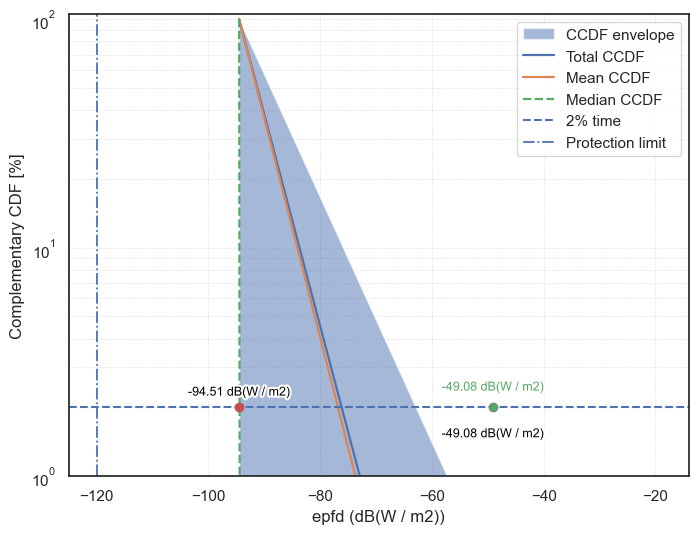

In [87]:
fig=plot_S_1586_1_cdf_ccdf_bounds(arr, show_two_percent=True, show_five_percent=False, y_min_percent=1, plot_type='ccdf',
                         show_total=True, show_bounds=True,show_mean=True,show_median=True, prot_value=-120, 
                         prot_legend=["Protection limit"])

In [7]:
def s1586_cell_bounds():
    # same construction as in plot_S_1586_1_hemisphere_power()
    s1586_az_steps = {
        0:3,3:3,6:3,9:3,12:3,15:3,18:3,21:3,24:3,27:3,
        30:4,33:4,36:4,39:4,42:4,45:4,
        48:5,51:5,54:5,57:6,60:6,63:6,66:8,69:9,72:10,
        75:12,78:18,81:24,84:40,87:120
    }
    el_edges = np.arange(0, 93, 3.0)
    az_lo=[]; az_hi=[]; el_lo=[]; el_hi=[]
    for i in range(len(el_edges)-1):
        el0, el1 = el_edges[i], el_edges[i+1]
        step = s1586_az_steps[el0]
        n = 360//step
        edges = np.arange(n+1)*step
        for j in range(n):
            az_lo.append(edges[j]); az_hi.append(edges[j+1])
            el_lo.append(el0); el_hi.append(el1)
    az_lo=np.array(az_lo); az_hi=np.array(az_hi)
    el_lo=np.array(el_lo); el_hi=np.array(el_hi)
    el_mid = 0.5*(el_lo+el_hi)
    return el_mid, el_lo, el_hi

def per_cell_percentile(arr, *, worst_percent=2.0, log_mode=True):
    # arr shape (time, 2334); returns 2334-length vector (same unit if Quantity)
    vals, unit = _to_plain_array(arr)
    if log_mode:
        lin = 10**(vals/10.0)
        pct = np.nanpercentile(lin, 100.0 - worst_percent, axis=0)
        out = 10*np.log10(np.maximum(pct, np.finfo(float).tiny))
    else:
        out = np.nanpercentile(vals, 100.0 - worst_percent, axis=0)
    return out * unit if unit is not None else out

# --- run it
el_mid, _, _ = s1586_cell_bounds()
per_cell_98 = per_cell_percentile(arr, worst_percent=2.0, log_mode=True)

# bin by elevation (3° rings) and compute robust stats
rings = np.unique(el_mid)
ring_med = []
ring_p95 = []
for r in rings:
    sel = (el_mid == r)
    ring_med.append(np.nanmedian(per_cell_98[sel]))
    ring_p95.append(np.nanpercentile(per_cell_98[sel], 95))
# quick look in text:
for r, m, p in zip(rings, ring_med, ring_p95):
    print(f"El {r:>4.0f}° : median={m:.2f}, 95th={p:.2f}")

El    2° : median=-90.65 dB(W / m2), 95th=-90.00 dB(W / m2)
El    4° : median=-90.11 dB(W / m2), 95th=-88.93 dB(W / m2)
El    8° : median=-84.48 dB(W / m2), 95th=-84.43 dB(W / m2)
El   10° : median=-83.95 dB(W / m2), 95th=-83.93 dB(W / m2)
El   14° : median=-83.83 dB(W / m2), 95th=-83.78 dB(W / m2)
El   16° : median=-83.75 dB(W / m2), 95th=-83.74 dB(W / m2)
El   20° : median=-83.73 dB(W / m2), 95th=-83.72 dB(W / m2)
El   22° : median=-83.72 dB(W / m2), 95th=-83.68 dB(W / m2)
El   26° : median=-83.66 dB(W / m2), 95th=-83.62 dB(W / m2)
El   28° : median=-83.57 dB(W / m2), 95th=-83.55 dB(W / m2)
El   32° : median=-83.54 dB(W / m2), 95th=-83.54 dB(W / m2)
El   34° : median=-83.55 dB(W / m2), 95th=-83.55 dB(W / m2)
El   38° : median=-83.56 dB(W / m2), 95th=-83.55 dB(W / m2)
El   40° : median=-83.53 dB(W / m2), 95th=-83.47 dB(W / m2)
El   44° : median=-83.37 dB(W / m2), 95th=-83.31 dB(W / m2)
El   46° : median=-82.74 dB(W / m2), 95th=-81.16 dB(W / m2)
El   50° : median=-81.16 dB(W / m2), 95t

In [8]:
# top 10 cells by per-cell 98th percentile
idx = np.argsort(per_cell_98)[::-1][:10]
for i in idx:
    print(f"cell {i:4d}  el~{el_mid[i]:.1f}°  value={per_cell_98[i]:.2f}")


cell 2289  el~79.5°  value=-80.98 dB(W / m2)
cell 2288  el~79.5°  value=-80.98 dB(W / m2)
cell 2290  el~79.5°  value=-80.98 dB(W / m2)
cell 2287  el~79.5°  value=-80.98 dB(W / m2)
cell 2291  el~79.5°  value=-80.98 dB(W / m2)
cell 2292  el~79.5°  value=-80.98 dB(W / m2)
cell 2286  el~76.5°  value=-80.98 dB(W / m2)
cell 2293  el~79.5°  value=-80.98 dB(W / m2)
cell 2285  el~76.5°  value=-80.98 dB(W / m2)
cell 2284  el~76.5°  value=-80.98 dB(W / m2)
